In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
wavenumber = 0.4
deg = 10

In [3]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [4]:
h = 0.08
cube1 = bempp.api.shapes.cube(length = 2, origin=(-8,-1,-1), h = h)
cube2 = bempp.api.shapes.cube(length = 2, origin=(2,-1,-1), h = h)
combined_scatters = bempp.api.grid.grid.union([cube1,cube2])

unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_unit_sphere = unit_sphere.vertices
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

space_cube1 = bempp.api.function_space(cube1, "P", 1)
space_cube2 = bempp.api.function_space(cube2, "P", 1)
space_combined = bempp.api.function_space(combined_scatters,'P',1)
######################-------------set scatterers and spaces----------------#########################
slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube1, space_cube1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2, space_cube1, space_cube1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube2, space_cube2, wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2, space_cube2, space_cube2, wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

p,l,u = scipy.linalg.lu(mat)
logdet_mat = 0
for i in range(u.shape[0]):
    logdet_mat += cmath.log(u[i,i])

p2,l2,u2 = scipy.linalg.lu(mat2)
logdet_mat2 = 0
for i in range(u2.shape[0]):
    logdet_mat2 += cmath.log(u2[i,i])

logdet = logdet_mat - logdet_mat2
lhs_value = 2*np.imag(logdet)*1j

In [36]:
eta = wavenumber

identity1 = bempp.api.operators.boundary.sparse.identity(space_cube1, space_cube1, space_cube1)
slp1 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube1, space_cube1, space_cube1, wavenumber)
dlp1 = bempp.api.operators.boundary.helmholtz.double_layer(space_cube1, space_cube1, space_cube1, wavenumber)
slp_far1 = helmholtz_farfield.single_layer(space_cube1, vert_unit_sphere, wavenumber)
dlp_far1 = helmholtz_farfield.double_layer(space_cube1, vert_unit_sphere, wavenumber)

lhs1 = 0.5 * identity1 + dlp1 - 1j* eta *slp1

identity2 = bempp.api.operators.boundary.sparse.identity(space_cube2, space_cube2, space_cube2)
slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_cube2, space_cube2, space_cube2, wavenumber)
dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_cube2, space_cube2, space_cube2, wavenumber)
slp_far2 = helmholtz_farfield.single_layer(space_cube2, vert_unit_sphere, wavenumber)
dlp_far2 = helmholtz_farfield.double_layer(space_cube2, vert_unit_sphere, wavenumber)

lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2

identity = bempp.api.operators.boundary.sparse.identity(space_combined, space_combined, space_combined)
slp = bempp.api.operators.boundary.helmholtz.single_layer(space_combined, space_combined, space_combined, wavenumber)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_combined, space_combined, space_combined, wavenumber)
slp_far = helmholtz_farfield.single_layer(space_combined, vert_unit_sphere, wavenumber)
dlp_far = helmholtz_farfield.double_layer(space_combined, vert_unit_sphere, wavenumber)

lhs = 0.5 * identity + dlp - 1j* eta *slp

sph_harm_coeff = []

for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def sph_harm(x,n,domain_index,result):
            with objmode():
                result[0] = normalized_spherical_harmonics(p,q,x)
        sph_harm_grid = bempp.api.GridFunction(space_unit_sphere, fun = sph_harm)
        sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere, space_unit_sphere, space_unit_sphere).weak_form().A

In [37]:
slp_far_field_coeff1 = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)

        rhs_fun1 = bempp.api.GridFunction(space_cube1, fun = dirichlet_fun)
        field1, info1 = bempp.api.linalg.gmres(lhs1, rhs_fun1, tol=1E-8)
        slp_far_field_coeff1.append(dlp_far1.evaluate(field1) - 1j * eta * slp_far1.evaluate(field1))

In [38]:
slp_far_field_coeff2 = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)
        rhs_fun2 = bempp.api.GridFunction(space_cube2, fun = dirichlet_fun)
        field2, info2 = bempp.api.linalg.gmres(lhs2, rhs_fun2, tol=1E-8)
        slp_far_field_coeff2.append(dlp_far2.evaluate(field2) - 1j * eta * slp_far2.evaluate(field2))

In [39]:
slp_far_field_coeff = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)

        rhs_fun = bempp.api.GridFunction(space_combined, fun = dirichlet_fun)
        field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-8)
        slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))

In [40]:
T_matrix1 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix1[i,j] = (slp_far_field_coeff1[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

T_matrix2 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix2[i,j] = (slp_far_field_coeff2[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

S_matrix = np.identity(T_matrix.shape[0]) + 2*T_matrix
S_matrix1 = np.identity(T_matrix1.shape[0]) + 2*T_matrix1
S_matrix2 = np.identity(T_matrix2.shape[0]) + 2*T_matrix2

rhs_value_S =  -(np.log(np.linalg.det(S_matrix))-(np.log(np.linalg.det(S_matrix1)) + np.log(np.linalg.det(S_matrix2))))

err = np.linalg.norm((rhs_value_S - lhs_value)/lhs_value)
print(h,deg,err)

0.08 10 0.004751715976007307


In [ ]:
0.05 5 0.0015152884285827039
0.06 5 0.0023608329409344235
0.07 5 0.0040233538222573025
0.08 5 0.004636808980189945
0.09 5 0.00770325537304249
0.1 5 0.009538101721776717

0.08 10 0.004751715976007307
0.09 10 0.007828426053879806
0.1 10 0.009640338861984494

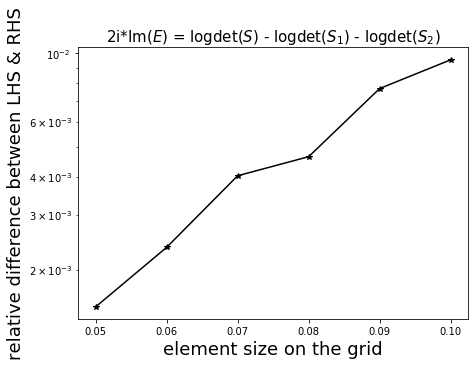

In [78]:
new_list = [0.009538101721776717, 0.00770325537304249, 0.004636808980189945, 0.0040233538222573025,  0.0023608329409344235, 0.0015152884285827039 ]
x_list = [0.1, 0.09,0.08,0.07,0.06,0.05]
plt.figure(figsize = (7,5))
plt.semilogy(x_list,new_list, 'k-*')
plt.xlabel('element size on the grid', fontsize = 18)
plt.ylabel('relative difference between LHS & RHS', fontsize = 18)
plt.title('2i*Im($E$) = logdet($S$) - logdet($S_{1}$) - logdet($S_{2}$)', fontsize = 15)
plt.savefig('deg5 relative difference.pdf',bbox_inches='tight')

In [ ]:
list_1 = [error_list[0],error_list[4],error_list[8],error_list[12],error_list[16],error_list[20]]
list_2 = [error_list[1],error_list[5],error_list[9],error_list[13],error_list[17],error_list[21]]
list_3 = [error_list[2],error_list[6],error_list[10],error_list[14],error_list[18],error_list[22]]
list_4 = [error_list[3],error_list[7],error_list[11],error_list[15],error_list[19],error_list[23]]

In [ ]:
x_axis = [5,7,9,11,13,15]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim(0.004,0.1)
plt.semilogy(x_axis,list_1,label='0.03')
plt.semilogy(x_axis,list_2,label='0.05')
plt.semilogy(x_axis,list_3,label='0.07')
plt.semilogy(x_axis,list_4,label='0.09')
plt.xlabel('Degree of spherical expansion-Cube')
plt.ylabel('Error by comparing the far fields' )
plt.legend()
#plt.savefig('Converge by refining the grid3-Cube.pdf')

In [ ]:
list_11 = error_list[0:4]
list_22 = error_list[4:8]
list_33 = error_list[8:12]
list_44 = error_list[12:16]
list_55 = error_list[16:20]
list_66 = error_list[20:24]

In [ ]:
x_axis_fix_deg = [0.03,0.05,0.07,0.09]
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_ylim(0.004,0.1)
plt.semilogy(x_axis_fix_deg,list_33, 'r+-')
#plt.semilogy(x_axis,list_2,label='0.05')
#plt.semilogy(x_axis,list_3,label='0.07')
#plt.semilogy(x_axis,list_4,label='0.09')
plt.xlabel('refinment level')
plt.ylabel('Error' )
#plt.legend()
#plt.savefig('Converge by refining the grid3-Cube.pdf')

In [ ]:
0.1 5 0.006214741118359156